#**RECURSOS**

---



##**Pacotes**

In [2]:
!pip install workalendar
!pip install pickle # Saving and loading objects 
!pip install catboost
!pip install pmdarima
import sklearn
sklearn.__version__

     |████████████████████████████████| 205 kB 4.5 MB/s 
     |████████████████████████████████| 70 kB 7.8 MB/s 
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
     |████████████████████████████████| 76.4 MB 26 kB/s 
     |████████████████████████████████| 1.4 MB 5.4 MB/s 
     |████████████████████████████████| 9.8 MB 47.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


'0.22.2.post1'

In [3]:
import sklearn
sklearn.__version__

'0.22.2.post1'

##**Bibliotecas**

In [4]:
#DATA
import numpy as np 
import pandas as pd 
import time

#SPLIT DATA
from sklearn.model_selection import train_test_split

#ANALISES
from scipy.stats import anderson

import statsmodels
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller

#CROSS VALIDATE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
# from sklearn.model_selection import TimeSeriesSplit

# METRICS 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

#PLOTS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

#XGBoost
from xgboost import XGBRegressor

#Noormalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

#Outliers
from sklearn.ensemble import IsolationForest

#WARNINGS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')


import pickle # Saving and loading objects 


##**Funções**

Tratment

In [5]:
# https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3

In [6]:
from sklearn.impute import SimpleImputer
import xgboost as xgb

def format_name_column(name_model):
    """
        Format the name of colunm.

        >Exemple

        full name: AAT.ASN.010.FIT.001.000.000
        initial name: 001 = 1
        initial name: VZ + 1
        importance: AAT.ASN.010
        
        name column: VZ1.AAT.ASN.010
    """
    name_column = name_model[0:11]
    name_ini = name_model[16:19]
    name_column = 'VZ'+str(int(name_ini))+'.'+name_column

    return name_column      

Models

In [7]:

def grid_arima(train,test,p_values,d_values,q_values,verbose=False):
  # train_size = int(len(X) * (1-test_size))
  # train, test = dataset[0:train_size], dataset[train_size:]
  best_err = float('inf')
  best_params = ''
  best_model =None
  for p,d,q in product(p_values,d_values,q_values):
      
      try:
        model = ARIMA(order=(p,d,q),
              seasonal_order=(1, 1, 1, 24),
              suppress_warnings=True)
        model_fit = model.fit(train)
        yhat = model_fit.predict(n_periods=len(test))
        MAE = mean_absolute_percentage_error(test,yhat)
        MSE = mean_squared_error(test,yhat)
        # if verbose:
        print("ARIMA({},{},{}) - MSE:{}  MAE:{}".format(p,d,q,MSE,MAE))
        if MAE < best_err:
          best_err = MAE
          best_params = "ARIMA({},{},{}) - MSE:{}  MAE:{}".format(p,d,q,MSE,MAE)
          best_model = model_fit
      except:
        continue
  return best_model
  
def load_model(path,name):
    # Load model 
    meu_arquivo = open(path + name,'rb') # Read file binary (rb)
    model_predict = pickle.load(meu_arquivo) # Load model

    return model_predict


def save_model(model,path,name):
    # >>> Save model trained
    my_file = open(path+name+'.p','wb') # Open archive for write(w) in binary(b)
    pickle.dump(model, my_file) # Discharges model in archive .p
    my_file.close() # Close archive
    

Metrics

In [8]:
def metrics_regression(y_true,y_pred):
    d = {}
    d['mean squared error'] = mean_squared_error(y_true, y_pred)
    d['root mean Squared error'] = mean_squared_error(y_true, y_pred,squared=False)
    d['median absolute error'] = median_absolute_error(y_true, y_pred)
    d['mean absolute error'] = mean_absolute_error(y_true, y_pred)
    d['r2 score'] = r2_score(y_true, y_pred)
    d['simetric mean absulute percentage error'] = smape(y_true, y_pred)
    return d

def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)

# Teste de Dickey Fuler
def test_dickey_fuller(dt,target):
    X = dt[target]
    result_sub = adfuller(X)
    print('Dickey-Fuller Aumentado')
    print("Estatistica:{:.4f}".format(result_sub[0]))
    print("p-value:{:.10f}".format(result_sub[1]))
    print("Valores criticos:")
    for key, value in result_sub[4].items():
        print("\t{} = {:.2f}".format(key,value))

def cross_val_score_predict(model,X_test,y_test,cv):

  result_crossval= {'SMAPE':[],'MSE':[],'MAE':[]}

  for train_idx,test_idx in cv.split(X_test):

      # model = model.fit(X_train.iloc[train_idx],y_train[train_idx],X_train.iloc[test_idx],y_test[test_idx])

      pred = model.predict(X_test.iloc[test_idx],y_test.iloc[test_idx])

      result_crossval['SMAPE'].append(smape(y_test.iloc[test_idx].values,pred.reshape(-1,1)))
      result_crossval['MSE'].append(mean_squared_error(y_test.iloc[test_idx].values,pred.reshape(-1,1)))
      result_crossval['MAE'].append(mean_absolute_error(y_test.iloc[test_idx].values,pred.reshape(-1,1)))
  return result_crossval

In [9]:
smape_score = make_scorer(smape)
mean_squared_error_score = make_scorer(mean_squared_error)
mean_absolute_error_score = make_scorer(mean_absolute_error)

In [10]:
metrics_models = {}

Plots

In [11]:
def plots_model(train,test,y_pred,title):
  plt.subplots(figsize=(35,10))
  plt.plot(train.index,train,color='#3366ff')
  plt.plot(test.index,test,color='#ff3300')
  plt.plot(test.index,y_pred,color='#33cc33')
  plt.title(title,fontsize=20,fontweight='bold')
  plt.yticks(fontsize=13,fontweight='bold')
  plt.xticks(fontsize=13,fontweight='bold')
  plt.ylabel('Flow',fontsize=15)
  plt.xlabel('Date',fontsize=15)
  plt.show()

  plt.subplots(figsize=(35,10))
  plt.plot(test.index,test,color='#ff3300')
  plt.plot(test.index,y_pred,color='#33cc33')
  plt.title(title+' test',fontsize=20,fontweight='bold')
  plt.yticks(fontsize=13,fontweight='bold')
  plt.xticks(fontsize=13,fontweight='bold')
  plt.ylabel('Flow',fontsize=15)
  plt.xlabel('Date',fontsize=15)
  plt.show()

def error_plot(y_true,y_pred,title):
  error = y_pred - y_true

  plt.subplots(figsize=(30,10))

  plt.hist(error, bins = 25)
  plt.xlabel("Prediction Error [FLOW]")
  plt.ylabel("Count")
  plt.title('Prediction Error',fontsize=20,fontweight='bold')
  plt.tight_layout()


  plt.subplots(figsize=(15,7))
  plt.scatter(y_true, y_pred)
  plt.xlabel('True Values [FLOW]')
  plt.ylabel('Predictions [FLOW]')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([0,plt.xlim()[1]])
  plt.ylim([0,plt.ylim()[1]])
  plt.xticks(fontweight='bold',fontsize=15)
  plt.yticks(fontweight='bold',fontsize=15)
  plt.title(title,fontweight='bold',fontsize=20)
  _ = plt.plot([-100, 300], [-100, 300])


def plot_history_tf(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.subplots(figsize=(30,10))
  plt.xlabel('Epoch',fontsize=15)
  plt.ylabel('Mean Abs Error [FLOW]',fontsize=15)
  plt.plot(hist['epoch'], hist['mae'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
  plt.yticks(fontweight='bold',fontsize=12)
  plt.xticks(fontweight='bold',fontsize=12)
  plt.legend()

  plt.subplots(figsize=(30,10))
  plt.xlabel('Epoch',fontsize=15)
  plt.ylabel('Mean Square Error [$FLOW^2$]',fontsize=15)
  plt.plot(hist['epoch'], hist['mse'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
  plt.yticks(fontweight='bold',fontsize=12)
  plt.xticks(fontweight='bold',fontsize=12)
  plt.legend()
  plt.show()

**Nomalizar**

In [12]:
# class MyScaler():
#   def __init__(self,X,standard_scaler=None,power_transformer=None):
#     self.power_transformer = power_transformer
#     self.standard_scaler = standard_scaler
#     self.scaler = None
#     self.power = None

#   def fit(self,X):
#     if self.standard_scaler == True:
#       self.scaler = StandardScaler().fit(X[self.standard_scaler])

#     if self.power_transformer == True:
#       self.power = PowerTransformer().fit(X[self.power_transformer])

#     return self

#   def transform(self,X):
#     if self.standard_scaler == True and  self.power_transformer == True:
#       scaler_result = self.scaler.transform(X[self.standard_scaler])
#       power_result = self.power.transform(X[self.power_transformer])
#       return np.concatenate((scaler_result,power_result),axis=1)

#     elif self.standard_scaler == True: 
#       return self.scaler.transform(X[self.standard_scaler])

#     elif self.power_transformer == True:  
#       return self.power.transform(X[self.power_transformer])

#   def inverse_transform(self,X):
#     if self.standard_scaler == True and  self.power_transformer == True:
#       scaler_result = self.scaler.inverse_transform(X[self.standard_scaler])
#       power_result = self.power.inverse_transform(X[self.power_transformer])
#       return np.concatenate((scaler_result,power_result),axis=1)

#     elif self.standard_scaler == True: 
#       return self.scaler.inverse_transform(X[self.standard_scaler])

#     elif self.power_transformer == True:  
#       return self.power.inverse_transform(X[self.power_transformer])

#**1. Extração de dados**

---






In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
path = '/content/drive/MyDrive/GitHub/analise/DATA/'
path_models = '/content/drive/MyDrive/GitHub/analise/MODELS/'
path_metrics = '/content/drive/MyDrive/GitHub/analise/METRICS/'

In [15]:
file_targets = path+r'base_training.xlsx'
file_features = path+r'INMET.xlsx'

In [16]:
columns = ['DATE','AAT.PLT.050.FIT.001.000.000']

year = 2020

# Read target columns
df_flows = pd.read_excel(file_targets,index_col='DATE',usecols=columns,converters={'Bad':0}).apply(lambda x: x.replace('Bad',np.nan))
df_flows = df_flows.loc[(df_flows.index.year == year)] # Define year

# Read feature columns
df_features = pd.read_excel(file_features,index_col='DATE')
df_features = df_features.loc[(df_features.index.year == year)] # Define year

In [17]:
x = df_features.reset_index(drop=True)
y = df_flows.reset_index()

column = y.columns[1]

# Treatment of data
df = pd.concat([round(y,2),round(x)],axis=1) # Concat the target column and the features columns
df.rename({column:'FLOW'},axis=1,inplace=True) # Rename column to FLOW
df.set_index('DATE',inplace=True) # Set index of Data Frame

#**2. Compreensão dados**

---





##**2.1 Criação e seleção de váriaveis**




In [18]:
df_aux = df.copy()
df_aux['date'] = df.index

df['hour'] = df_aux['date'].dt.hour
df['dayofweek'] = df_aux['date'].dt.dayofweek
df['quarter'] = df_aux['date'].dt.quarter
df['month'] = df_aux['date'].dt.month

df = df[['FLOW','hour','month','dayofweek','F','N','Q']]

**Hipoteses**



*   Correlação entre as váriaveis climática e de consumo de água
*   Correlação entre as váriaveis sazonais e de consumo de água




##**2.2 Descrevendo os dados**#

In [19]:
data_clean = df.dropna(axis=0)

In [20]:
df.head(4)

,FLOW,hour,month,dayofweek,F,N,Q
DATE,,,,,,,
2020-01-01 00:00:00,97.47,0,1,2,20.0,89.0,1.0
2020-01-01 01:00:00,89.65,1,1,2,20.0,91.0,0.0
2020-01-01 02:00:00,91.81,2,1,2,20.0,93.0,1.0
2020-01-01 03:00:00,85.54,3,1,2,20.0,91.0,1.0


In [21]:
df_flows.describe().T

,count,mean,std,min,25%,50%,75%,max
AAT.PLT.050.FIT.001.000.000,8724.0,169.570786,58.624516,65.739477,109.059723,186.080902,219.903537,287.440776


In [22]:
pd.concat([df_flows,df_features],axis=1).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   AAT.PLT.050.FIT.001.000.000  8724 non-null   float64
 1   A                            8784 non-null   float64
 2   B                            8784 non-null   float64
 3   C                            8784 non-null   float64
 4   D                            8784 non-null   float64
 5   E                            8784 non-null   float64
 6   F                            8784 non-null   float64
 7   G                            8784 non-null   float64
 8   H                            8784 non-null   float64
 9   I                            8784 non-null   float64
 10  J                            8784 non-null   float64
 11  K                            8784 non-null   float64
 12  L                            8784 non-nu

Pode-se observar que o dado target tem seu valor minimo sendo igual a 0, o que pode significar possiveis outliers dado a natureza dos dados.



In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
FLOW,8724.0,169.570757,58.624535,65.74,109.0625,186.08,219.9025,287.44
hour,8784.0,11.500000,6.922581,0.00,5.7500,11.50,17.2500,23.00
month,8784.0,6.513661,3.451430,1.00,4.0000,7.00,10.0000,12.00
dayofweek,8784.0,2.997268,1.995325,0.00,1.0000,3.00,5.0000,6.00
F,8784.0,21.348702,3.958842,9.00,19.0000,21.00,24.0000,36.00
N,8784.0,67.105191,21.735581,10.00,50.0000,70.00,87.0000,97.00
Q,8784.0,2.249431,1.139006,0.00,1.0000,2.00,3.0000,7.00


In [24]:
from scipy.stats import variation 
print('Variação:',variation(data_clean['FLOW'], axis=0))

Variação: 0.3457033307709369


**Estacionariedade**

Constata-se que a série histórica é estacionária.

In [25]:
from pmdarima.arima import ADFTest
adftest = ADFTest(alpha=(0.05))
adft = adftest.should_diff(data_clean['FLOW'])
print('Reject:',adft[1])
print('p =',adft[0])

Reject: False
p = 0.01


Dickey-Fuller Aumentado
Estatistica:-7.2068
p-value:0.0000000002
Valores criticos:
	1% = -3.43
	5% = -2.86
	10% = -2.57
None


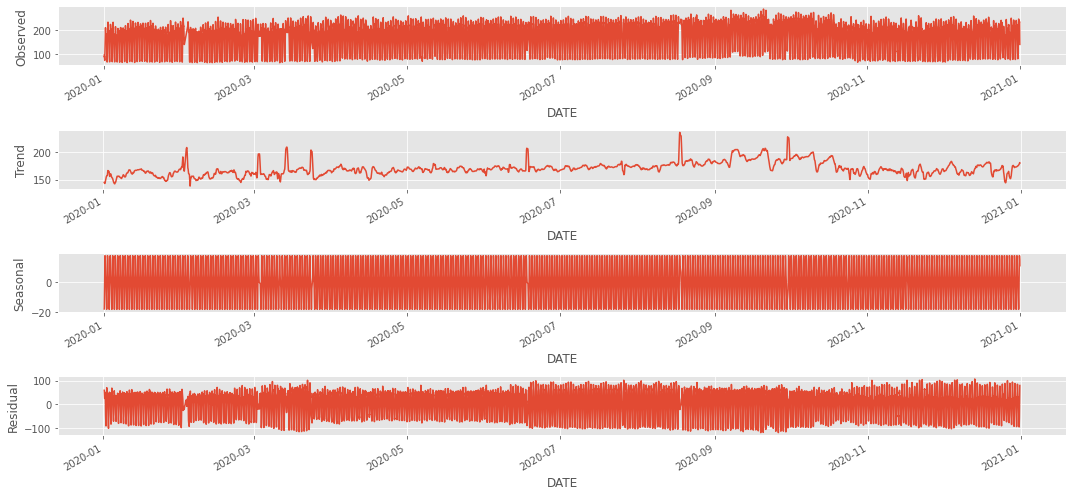

In [26]:
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose

print(test_dickey_fuller(data_clean,target='FLOW'))

# salvar os componentes da *time series* na variável results
result = seasonal_decompose(data_clean['FLOW'],period=24)

# plotar componentes
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,7))

result.observed.plot(ax=ax1,ylabel ='Observed')
result.trend.plot(ax=ax2,ylabel='Trend')
result.seasonal.plot(ax=ax3,ylabel='Seasonal')
result.resid.plot(ax=ax4,ylabel='Residual')
plt.tight_layout()



##**2.3 Exploração dos dados**

>**3.1 Vazão, densidade e humidade**

Nota-se que existe uma correlação diretamente proporcional entre a humidade e vazão de água. Isso se da pelo fato que quanto maior a humidade, maior a sensação térmica e o consumo de água.

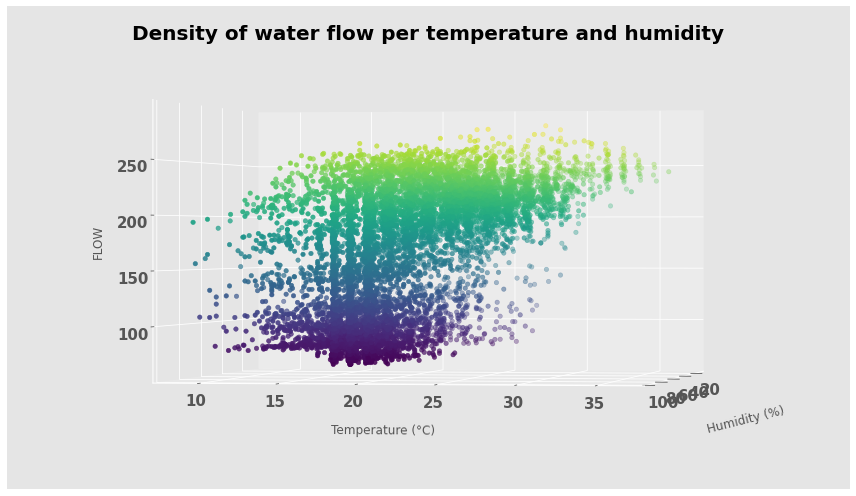

In [27]:
# Grafico de densidade
fig = plt.figure(figsize=(12,7))
eixos = plt.axes(projection="3d")
    
data = df[['FLOW','F','N']]

x = data['N']
y = data['F']
z = data['FLOW']

eixos.scatter3D(x, y, z, c=z, cmap='viridis');  
eixos.elev = 0.1
eixos.dist =10
eixos.azim = 10

plt.style.use('ggplot')
plt.title('Density of water flow per temperature and humidity',fontweight='bold',fontsize=20)
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontsize(15)
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontweight('bold')
eixos.set_zlabel('FLOW', fontsize=12,labelpad=10,rotation=90)

plt.yticks(fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=15)
plt.ylabel('Temperature (°C)', fontsize=12,labelpad=30,)
plt.xlabel('Humidity (%)', fontsize=12,labelpad=30)

plt.tick_params()
plt.tight_layout()

É observado que quanto maior a temperatura, maior é o consumo de água.

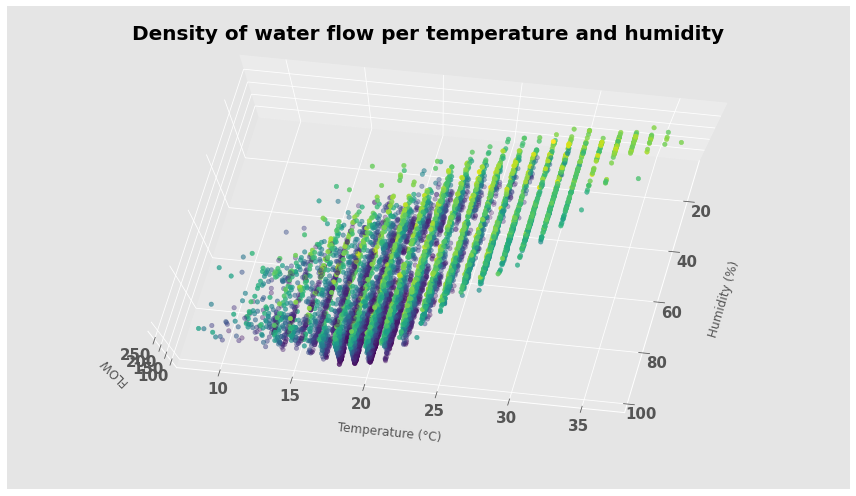

In [28]:
fig = plt.figure(figsize=(12,7))
eixos = plt.axes(projection="3d")

eixos.scatter3D(x, y, z, c=z, cmap='viridis');
eixos.elev = 80
eixos.dist =10
eixos.azim = 10

plt.style.use('ggplot')
plt.title('Density of water flow per temperature and humidity',fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold')
plt.xticks(fontweight='bold')
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontsize(15)
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontweight('bold')
eixos.set_zlabel('FLOW', fontsize=12,labelpad=10,rotation=135)

plt.yticks(fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=15)
plt.ylabel('Temperature (°C)', fontsize=12,labelpad=30,)
plt.xlabel('Humidity (%)', fontsize=12,labelpad=30)

plt.tight_layout()

O vento possuí um comportamento inversamente proporcional à temperatura, ou seja, quanto maior a velocidade do vento menor tende a ser a temperatura.

>**3.2 Vazão, temperatura e velocidade do vento**

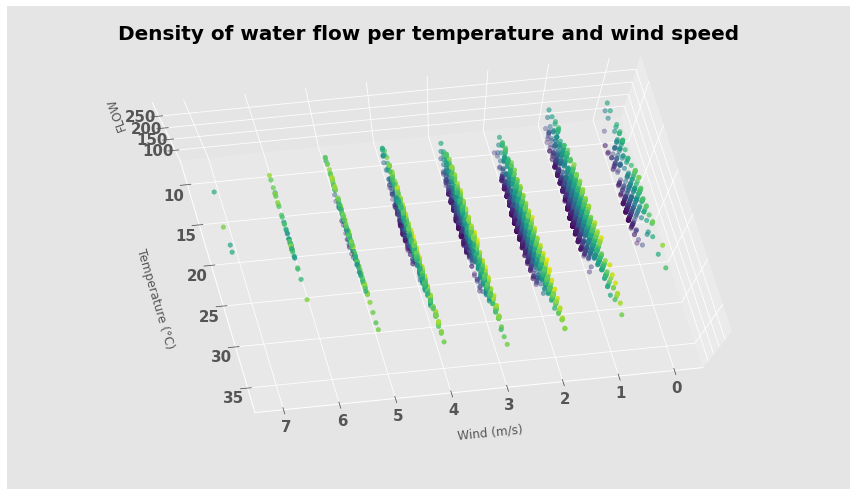

In [29]:
# Grafico de densidade
fig = plt.figure(figsize=(12,7))
eixos = plt.axes(projection="3d")
    
data = df[['FLOW','F','Q']]

x = data['Q']
y = data['F']
z = data['FLOW']

eixos.scatter3D(x, y, z, c=z, cmap='viridis');  
eixos.elev = 80
eixos.dist =10
eixos.azim = 80

plt.style.use('ggplot')
plt.title('Density of water flow per temperature and wind speed',fontweight='bold',fontsize=20)
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontsize(15)
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontweight('bold')
eixos.set_zlabel('FLOW', fontsize=12,labelpad=11,rotation=110)

plt.yticks(fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=15)
plt.ylabel('Temperature (°C)', fontsize=12,labelpad=30,)
plt.xlabel('Wind (m/s)', fontsize=12,labelpad=30)

plt.tick_params()
plt.tight_layout()

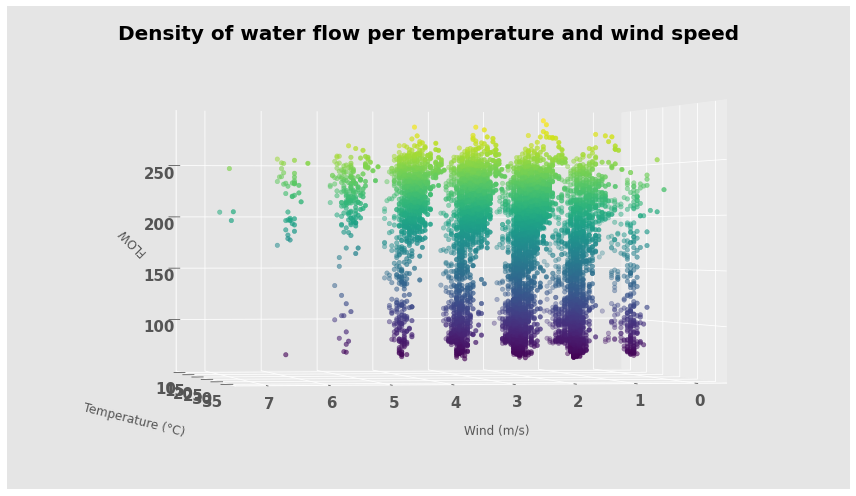

In [30]:
fig = plt.figure(figsize=(12,7))
eixos = plt.axes(projection="3d")

eixos.scatter3D(x, y, z, c=z, cmap='viridis');
eixos.elev = 0.1
eixos.dist =10
eixos.azim = 80

plt.style.use('ggplot')
plt.title('Density of water flow per temperature and wind speed',fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold')
plt.xticks(fontweight='bold')
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontsize(15)
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontweight('bold')
eixos.set_zlabel('FLOW', fontsize=12,labelpad=10,rotation=135)

plt.yticks(fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=15)
plt.ylabel('Temperature (°C)', fontsize=12,labelpad=30,)
plt.xlabel('Wind (m/s)', fontsize=12,labelpad=30)

plt.tight_layout()

>**3.3 Vazão, humidade e velocidade do vento**

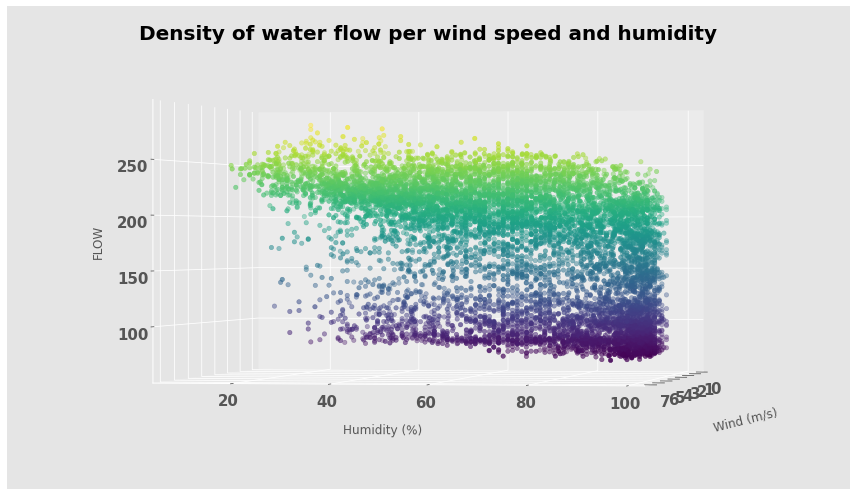

In [31]:
# Grafico de densidade
fig = plt.figure(figsize=(12,7))
eixos = plt.axes(projection="3d")
    
data = df[['FLOW','N','Q']]

x = data['Q']
y = data['N']
z = data['FLOW']

eixos.scatter3D(x, y, z, c=z, cmap='viridis');  
eixos.elev = 0.1
eixos.dist =10
eixos.azim = 10

plt.style.use('ggplot')
plt.title('Density of water flow per wind speed and humidity',fontweight='bold',fontsize=20)
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontsize(15)
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontweight('bold')
eixos.set_zlabel('FLOW', fontsize=12,labelpad=10,rotation=90)

plt.yticks(fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=15)
plt.ylabel('Humidity (%)', fontsize=12,labelpad=30,)
plt.xlabel('Wind (m/s)', fontsize=12,labelpad=30)

plt.tick_params()
plt.tight_layout()

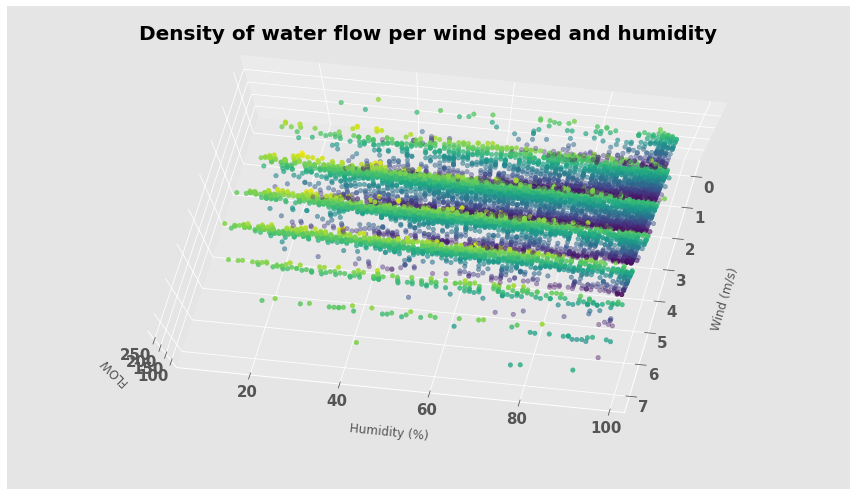

In [32]:
fig = plt.figure(figsize=(12,7))
eixos = plt.axes(projection="3d")

eixos.scatter3D(x, y, z, c=z, cmap='viridis');
eixos.elev = 80
eixos.dist =10
eixos.azim = 10

plt.style.use('ggplot')
plt.title('Density of water flow per wind speed and humidity',fontweight='bold',fontsize=20)
plt.yticks(fontweight='bold')
plt.xticks(fontweight='bold')
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontsize(15)
for t in eixos.zaxis.get_major_ticks(): t.label.set_fontweight('bold')
eixos.set_zlabel('FLOW', fontsize=12,labelpad=10,rotation=135)

plt.yticks(fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=15)
plt.ylabel('Humidity (%)', fontsize=12,labelpad=30,)
plt.xlabel('Wind (m/s)', fontsize=12,labelpad=30)

plt.tight_layout()

> **3.4 Sazonalidades** 

Já a sazonalidade apresenta um comportamento muito bem definido em relação ao consumo hidrico. Em particular, a hora possuí a maior diferença de variação entre faixas de vazão por hora.

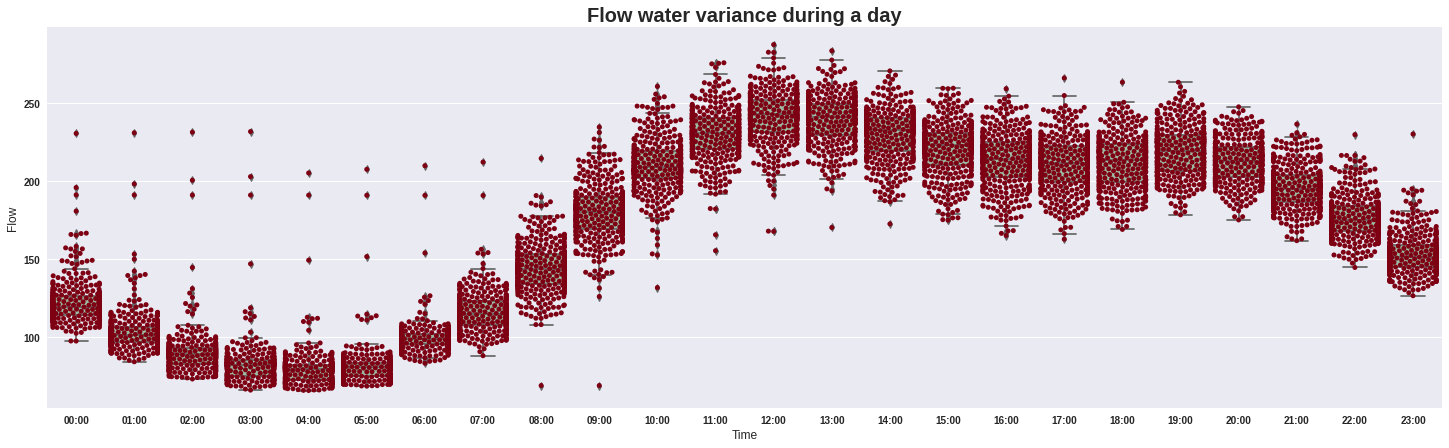

In [33]:
plt.style.use('seaborn')
plt.figure(figsize=[25,7])
ax = sns.boxplot(x='hour', y='FLOW', data=df, color='#99c2a2')
ax = sns.swarmplot(x='hour', y='FLOW', data=df,  color='#7d0013')
plt.title('Flow water variance during a day',fontweight='bold',fontsize=20)

dt = pd.date_range(start='2018-08-08', end = '2018-08-9', freq='H').strftime("%H:%M")

plt.xticks(range(0,24),dt,fontweight='bold',fontsize=10)
plt.yticks(fontweight='bold',fontsize=10)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Flow',fontsize=12)
plt.show(ax)

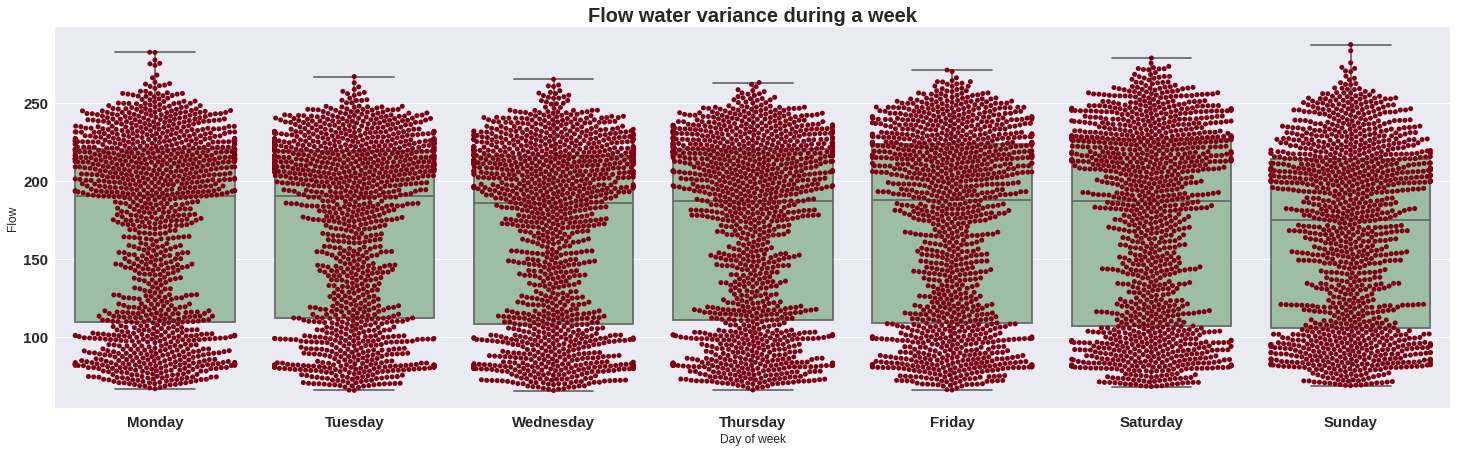

In [34]:
plt.figure(figsize=[25,7])
ax = sns.boxplot(x='dayofweek', y='FLOW', data=df, color='#99c2a2')
ax = sns.swarmplot(x="dayofweek", y="FLOW", data=df, color='#7d0013')
plt.xticks(range(0,7),['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],fontsize=15,fontweight='bold')
plt.yticks(fontsize=15,fontweight='bold')
plt.xlabel('Day of week',fontsize=12)
plt.ylabel('Flow',fontsize=12)
plt.title('Flow water variance during a week',fontsize=20,fontweight='bold')
plt.show(ax)

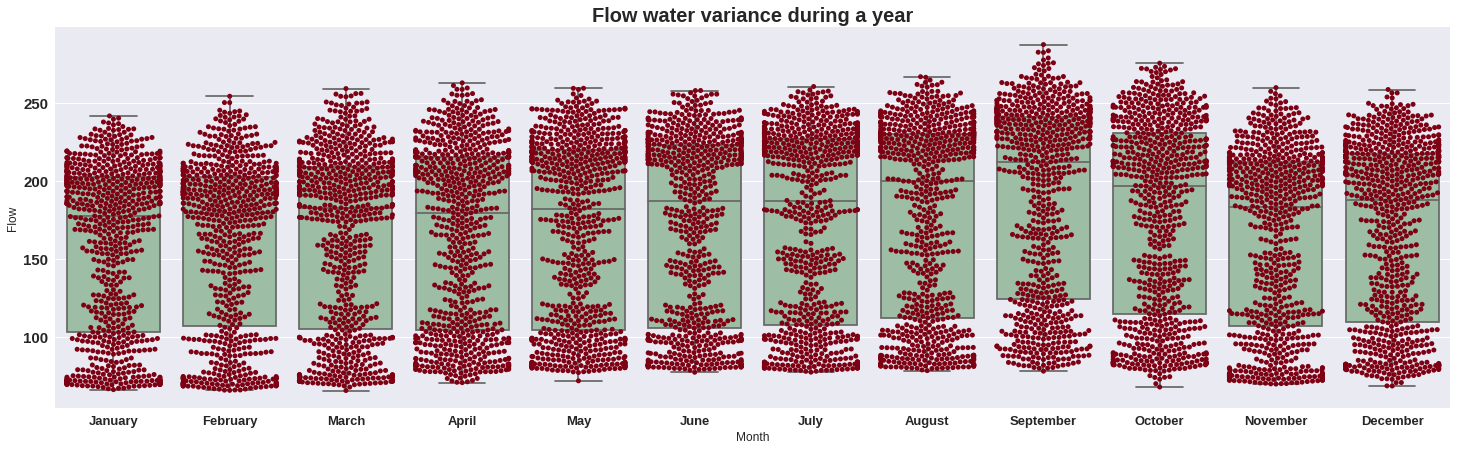

In [35]:
import calendar
plt.subplots(figsize=[25,7])
ax = sns.boxplot(x='month', y='FLOW', data=df, color='#99c2a2')
ax = sns.swarmplot(x="month", y="FLOW", data=df, color='#7d0013')

plt.title('Flow water variance during a year',fontweight='bold',fontsize=20)
ax.set_xticklabels([calendar.month_name[i] for i in pd.date_range(start='2020-01-01',end='2020-12-01').month.unique()])
plt.xticks(fontweight='bold',fontsize=13)
plt.yticks(fontweight='bold',fontsize=15)

plt.ylabel('Flow',fontsize=12)
plt.xlabel('Month',fontsize=12)
plt.show(ax)

##**2.4 Correlação dos dados**





>**4.2 Comportamento sazonal**

O modelo estatistico ANOVA mostra que sómente a variavel hora teve variancia significativa entre as variáveis categoricas temporais em relação a vazão, mostrando um pvalue menor que 5% e descartando a hipotese nula.

In [36]:
model_m = ols("FLOW ~ dayofweek+month+hour", data=df).fit()
anova_table_m  = sm.stats.anova_lm(model_m, typ=1)
display(print("\nANOVA"),anova_table_m) 


ANOVA


None

,df,sum_sq,mean_sq,F,PR(>F)
dayofweek,1.0,1.688479e+03,1.688479e+03,0.920678,3.373237e-01
month,1.0,1.789405e+05,1.789405e+05,97.570957,6.850729e-23
hour,1.0,1.380683e+07,1.380683e+07,7528.453005,0.000000e+00
Residual,8720.0,1.599207e+07,1.833953e+03,NaN,NaN


>**4.1 Teste de Tukey**

In [37]:
# TEST TUKEY CORRELACTION HOUR
mc = statsmodels.stats.multicomp.MultiComparison(data_clean['FLOW'],data_clean['hour'])
mc_results = mc.tukeyhsd()
print(mc_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1 -18.8077  0.001 -22.9143  -14.701   True
     0      2 -32.1896  0.001 -36.2963  -28.083   True
     0      3   -39.43  0.001 -43.5367 -35.3234   True
     0      4 -42.7234  0.001 -46.8329 -38.6139   True
     0      5 -41.1253  0.001 -45.2376 -37.0129   True
     0      6 -22.7365  0.001 -26.8488 -18.6241   True
     0      7  -6.2139  0.001 -10.3291  -2.0987   True
     0      8  22.2559  0.001  18.1464  26.3653   True
     0      9  57.4761  0.001  53.3723  61.5799   True
     0     10  87.9005  0.001  83.7939  92.0071   True
     0     11 108.0616  0.001 103.9635 112.1598   True
     0     12 118.9556  0.001 114.8575 123.0538   True
     0     13 116.7005  0.001 112.6023 120.7987   True
     0     14 107.2872  0.001 103.1918 111.3825   True
     0     15  98.2538  0.001  94.1584 102.3491   True
     0    

In [38]:
# TEST TUKEY WEEK
mc = statsmodels.stats.multicomp.MultiComparison(data_clean['FLOW'],data_clean['dayofweek'])
mc_results = mc.tukeyhsd()
print(mc_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1   0.1871    0.9  -6.7818   7.156  False
     0      2  -3.0805 0.8261  -9.9878  3.8268  False
     0      3   -0.607    0.9  -7.5129   6.299  False
     0      4   1.0835    0.9  -5.8458  8.0127  False
     0      5   2.1825    0.9  -4.7482  9.1131  False
     0      6  -4.7861 0.3925 -11.7126  2.1404  False
     1      2  -3.2676 0.7832 -10.2091  3.6739  False
     1      3   -0.794    0.9  -7.7342  6.1461  False
     1      4   0.8964    0.9   -6.067  7.8598  False
     1      5   1.9954    0.9  -4.9694  8.9601  False
     1      6  -4.9731 0.3489 -11.9338  1.9875  False
     2      3   2.4736    0.9  -4.4047  9.3519  False
     2      4    4.164 0.5533  -2.7377 11.0657  False
     2      5    5.263 0.2698  -1.6401 12.1661  False
     2      6  -1.7055    0.9  -8.6045  5.1934  False
     3      4   1.6904    0.

In [39]:
# TEST TUKEY MONTH

mc = statsmodels.stats.multicomp.MultiComparison(data_clean['FLOW'],data_clean['month'])
mc_results = mc.tukeyhsd()
print(mc_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2   1.8954    0.9  -8.1409  11.9317  False
     1      3   5.2675 0.8349  -4.6603  15.1953  False
     1      4   6.7631 0.5266  -3.1717  16.6979  False
     1      5   9.4642 0.0739   -0.389  19.3173  False
     1      6  11.4044 0.0102   1.4269  21.3818   True
     1      7   13.854  0.001   4.0008  23.7072   True
     1      8  19.1764  0.001   9.2999  29.0529   True
     1      9  29.7788  0.001  19.8192  39.7383   True
     1     10  19.4801  0.001    9.617  29.3432   True
     1     11   4.6437    0.9  -5.3017   14.589  False
     1     12   9.6736 0.0601  -0.1795  19.5268  False
     2      3   3.3721    0.9   -6.731  13.4753  False
     2      4   4.8677    0.9  -5.2423  14.9777  False
     2      5   7.5688 0.3628   -2.461  17.5986  False
     2      6    9.509 0.0914  -0.6429  19.6609  False
     2    

>**Correlação**


Pelo método de correlação de Spearman é possivel inferir que a vazão de agua  tem influência de variáveis climáticas como observado no valor de correlação de temperatura, humidade e velocidade do vento.

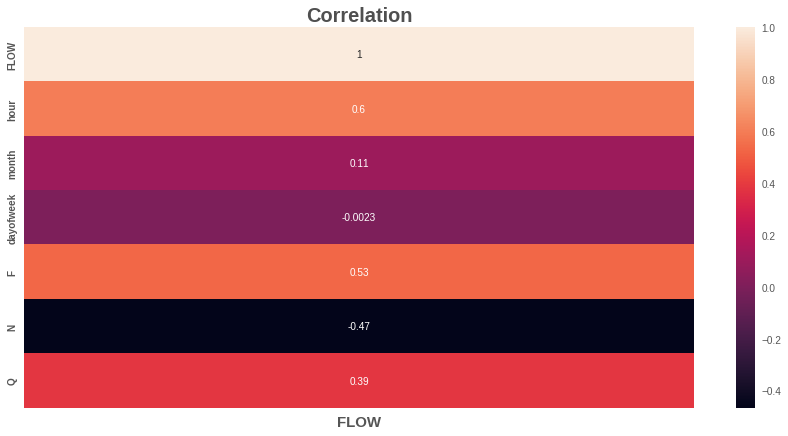

In [40]:
# CORRELAÇÃO
plt.style.use('ggplot')
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(method='spearman')[['FLOW']], annot=True)
plt.title('Correlation',fontsize=20,fontweight='bold',color='#4F4F4F')
plt.xticks(fontweight='bold',fontsize=15)
plt.yticks(fontweight='bold',fontsize=10)

plt.show()

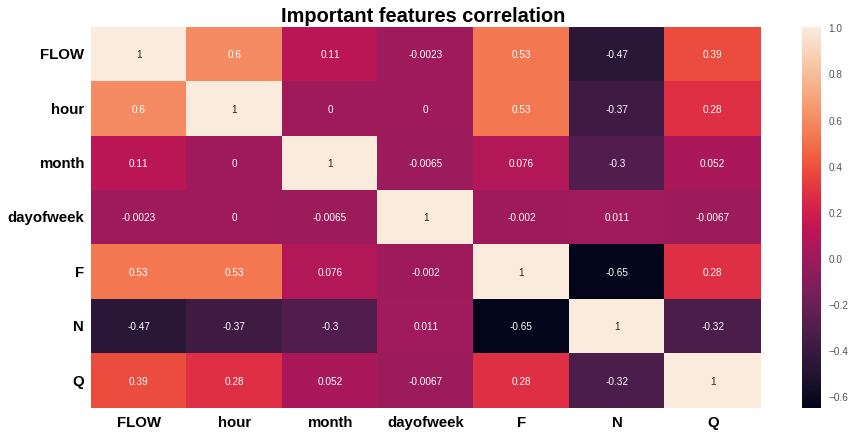

In [41]:
# CORRELAÇÃO
plt.style.use('ggplot')
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(method='spearman'), annot=True);
plt.title('Important features correlation ',fontsize=20,fontweight='bold',color='black')
plt.xticks(fontweight='bold',fontsize=15,color='black')
plt.yticks(fontweight='bold',fontsize=15,rotation=0,color='black')

plt.show()

Usando o modelo OLS de multiplos modelos estatisticos focando a observação nas métricas *R-squared,Adj*, *R-squared* e *Prob (F-statistic)* onde nos diz a 
correlação entre multiplas váriaveis obtemos um bom resultado.

A escolha das váriaveis climaticas foi baseada em recursos factiveis para o uso real do modelo preditivo.

In [42]:
model = ols("FLOW ~  F + N + Q + hour + month + dayofweek", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   FLOW   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     1702.
Date:                Sun, 10 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:51:42   Log-Likelihood:                -44513.
No. Observations:                8724   AIC:                         8.904e+04
Df Residuals:                    8717   BIC:                         8.909e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     65.8780      5.069     12.995      0.0



#**3. Tratamento**

---



O que podemos observar no grafico de de vazão são outliers artificiais multivariados. Artificiais pois são gerados possivelmente por falhas na medição e processamento.




Plotando o grafico de vazão de água é possivel observar claramente as falhas que existem na série histórica.

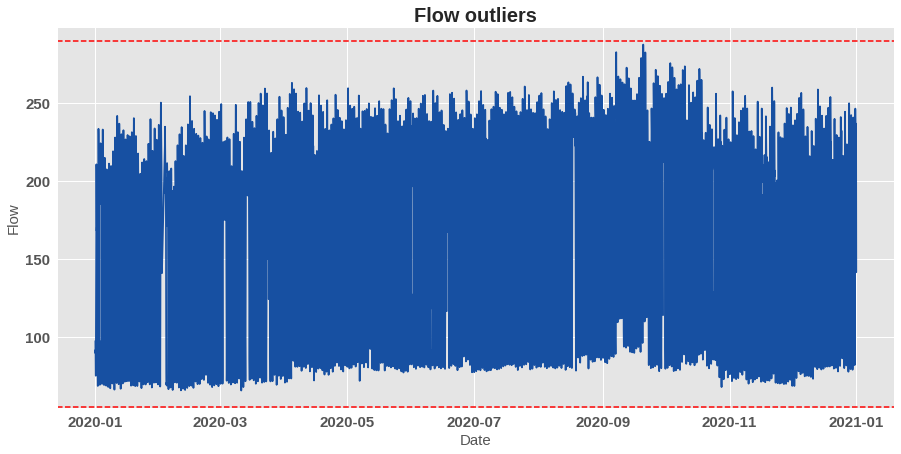

In [43]:
# OUTLIER E ERROS DE MEDIÇÃO
plt.subplots(figsize=(15,7))
data = df.FLOW
plt.plot(data.index,data.values,color='#1750A2')
plt.axhline(y=55,linestyle='--',color='#FE0202',linewidth=1.5)
plt.axhline(y=290,linestyle='--',color='#FE0202',linewidth=1.5)
plt.title('Flow outliers',fontweight='bold',fontsize=20)
plt.xticks(fontsize=15,fontweight='bold')
plt.yticks(fontsize=15,fontweight='bold')
plt.ylabel('Flow',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.show()

**Tratamento de outliers**



**Método de Tukey**





Para realizar o melhor tratamento possivel os dados são separados por subconjuntos divididos por dia da semana, hora e mês.
Em seguida é feita a troca desses outliers detectados pelo método de Tukey por nulos e preenchidos por nulos. Cada nulo será preenchido pela média do subconjunto respectivo.

In [44]:
# LIMPEZA
label = 'FLOW'

sc = StandardScaler()

sc.fit(df[label].values.reshape(-1,1))
for dofw in df.index.dayofweek.unique(): # Day of Week
    for h in df.index.hour.unique(): # Hours of day
          
          # Data Frame that contain 
          df_aux = df.loc[(df.index.dayofweek == dofw) & (df.index.hour == h),[label]]
          df_aux[label] = sc.transform(df_aux[label].values.reshape(-1,1))
          
          # Quartiles
          Q3 = df_aux.FLOW.quantile(0.75)

          Q1 = df_aux.FLOW.quantile(0.25)
          IQR = Q3 - Q1 # Interquantile
          
          # >>> Detection outliers and replace this values to nan.
          # Amplitudes:
          # lower limit = (Q1 - 1.5 * IQR)
          # upper limit = (Q3 + 1.5 * IQR)
          df_aux.loc[(df_aux[label] < (Q1 - 1.5 * IQR)) | (df_aux[label] > (Q3 + 1.5 * IQR))] = np.nan # Replace outliers for Nan
          
          # Imputation transformer for completing missing values.
          smpl = SimpleImputer(missing_values=np.NaN,strategy="median")
          
          # Fit model and replace the values Nan to the median
          # Build Data Frame whith ajusted values

          idf = pd.DataFrame(smpl.fit_transform(df_aux))

          # Define columns and index of the Data Frame
          idf.columns = df_aux.columns
          idf.index = df_aux.index

          idf[label] = sc.inverse_transform(idf[label].values.reshape(-1,1))
          # Overwrite outliers to the new values ajusted 
          df.loc[(df.index.dayofweek == dofw) & (df.index.hour == h),[label]] = idf[[label]]

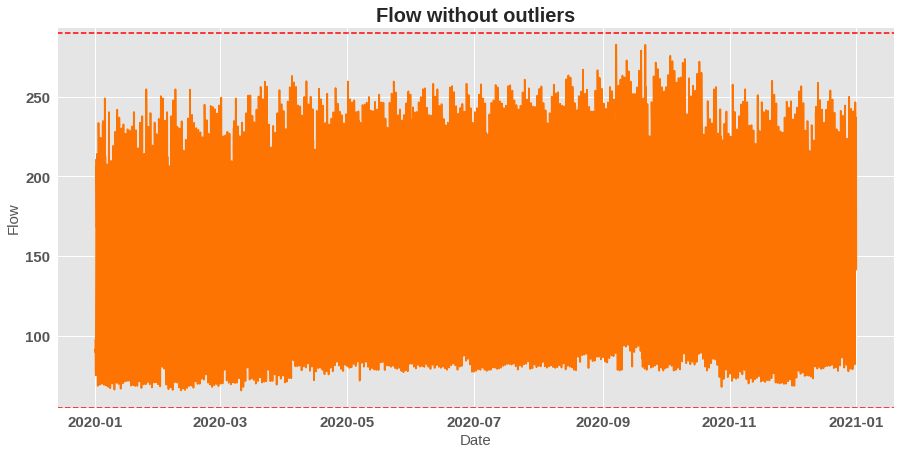

In [45]:
# OUTLIER REMOVIDOS
plt.subplots(figsize=(15,7))
data = df.FLOW
plt.plot(data.index,data.values,color='#FE7402')
plt.axhline(y=55,linestyle='--',color='#FE0202',linewidth=1.5)
plt.axhline(y=290,linestyle='--',color='#FE0202',linewidth=1.5)
plt.title('Flow without outliers',fontweight='bold',fontsize=20)
plt.xticks(fontsize=15,fontweight='bold')
plt.yticks(fontsize=15,fontweight='bold')
plt.ylabel('Flow',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.show()

**Distribuição normal**

Como o modelo XGBoost não precisa de normalização nem padronização das variaveis, não iremos nos preocupar em realizar esses procedimentos.

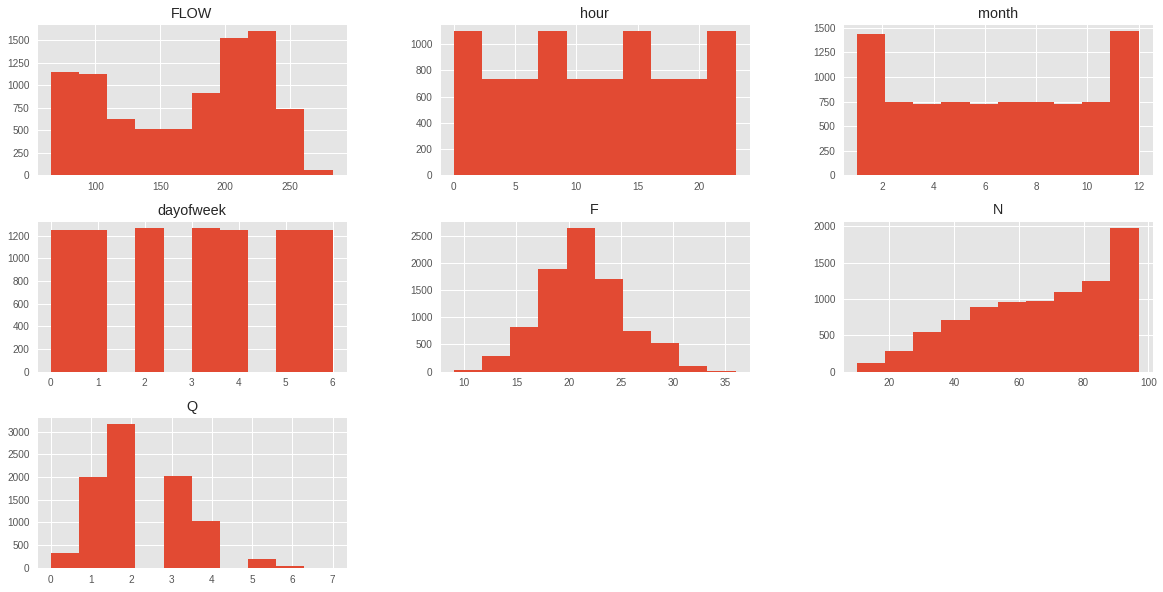

In [46]:
fig,ax = plt.subplots(figsize=(20,10))
df.hist(ax=ax)
plt.show()

#**4. Modelagem**
---



In [47]:
all_metrics_models = {}


##**4.1 Sepração dos dados**



In [48]:
df_ml = df.copy()

test_size = 0.2

flow_train, flow_test = train_test_split(df_ml, test_size=test_size,random_state=43)

X_flow_train = flow_train[['hour', 'month', 'dayofweek', 'F', 'N', 'Q']]
Y_flow_train = flow_train[['FLOW']]

X_flow_test = flow_test[['hour', 'month', 'dayofweek', 'F', 'N', 'Q']]
Y_flow_test = flow_test[['FLOW']]

# Creates new feature columns
X_train, y_train = X_flow_train,Y_flow_train
X_test, y_test   = X_flow_test.iloc[:int(len(flow_test)*0.5)], Y_flow_test.iloc[:int(len(flow_test)*0.5)]
X_eval, y_eval  = X_flow_test.iloc[int(len(flow_test)*0.5):], Y_flow_test.iloc[int(len(flow_test)*0.5):]

# For plot
train, test = train_test_split(df_ml, test_size=0.1,shuffle=False)

In [49]:
print('Train:',X_train.shape,y_train.shape)
print('Test:',X_test.shape,y_test.shape)
print('Validation:',X_eval.shape,y_eval.shape)

Train: (7027, 6) (7027, 1)
Test: (878, 6) (878, 1)
Validation: (879, 6) (879, 1)


##**4.2 Construção dos modelos**

###**4.2.3 XGBoost**

In [50]:
import pickle
from sklearn.base import BaseEstimator, ClassifierMixin
class XGBoostTrain():

  def __init__(self,num_boost_round=None,early_stopping_rounds=None,verbose=0,**kwargs):

    self.model = None
    self.verbose = verbose
    self.params = kwargs
    self.num_boost_round = num_boost_round
    self.early_stopping_rounds = early_stopping_rounds

  def fit(self,x_train,y_train,x_eval,y_eval):

    dtrain = xgb.DMatrix(x_train, label=y_train)
    deval = xgb.DMatrix(x_eval, label=y_eval)

    self.model = xgb.train(params = self.params,
                           dtrain = dtrain,
                           num_boost_round = self.num_boost_round,
                           evals = [(deval, "Test")],
                           early_stopping_rounds = self.early_stopping_rounds,
                           verbose_eval=self.verbose)
    return self

  def predict(self,x_test,y_test):
      dtest = xgb.DMatrix(x_test)
      return self.model.predict(dtest,ntree_limit = self.model.best_ntree_limit)

  def save(self,path):
     pickle.dump(self.model, open(path, "wb"))

  def load(self,path):
    self.model = pickle.load(open(path, "rb"))


####**4.2.3.1 Tuning hyperparameters**

In [51]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
deval = xgb.DMatrix(X_eval, label=y_eval)

In [52]:
from sklearn.model_selection import ParameterGrid
mdepth_minchild = {
                  'max_depth': [ i for i in range(3,13)],
                  'min_child_weight':[ i for i in range(1,9)],
                  }
gamma = {
        'gamma': [i/10.0 for i in range(0,5)]
        }
subsanple_colsample = {
                        'subsample':[i/10.0 for i in range(6,10)],
                        'colsample_bytree':[i/10.0 for i in range(6,10)]
                      }    
reg_alpha = {
            'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
            }   

learning_rate = {
                  'learning_rate': [i/100 for i in range(10,30)],
                }

num_parallel_tree = {

                  'num_parallel_tree': [i for i in range(10,300)],

                }

mdepth_minchild_grid = list(ParameterGrid(mdepth_minchild))
gamma_grid = list(ParameterGrid(gamma))
subsanple_colsample_grid = list(ParameterGrid(subsanple_colsample))
reg_alpha_grid = list(ParameterGrid(reg_alpha))
num_parallel_tree_grid = list(ParameterGrid(num_parallel_tree))
learning_rate_grid = list(ParameterGrid(learning_rate))

all_grid = [mdepth_minchild_grid,gamma_grid,subsanple_colsample_grid,reg_alpha_grid,num_parallel_tree_grid,learning_rate_grid]

In [53]:
# import xgboost as xgb
# from tqdm import tqdm
# from time import sleep
# # Define initial best params and MAE
# best_params = {}

# for i in range(len(all_grid)):
#   min_mae = float("Inf")
#   for params in tqdm(all_grid[i]):    
#     sleep(0.001)
#     # Run CV
#     params['eval_metric'] = "mae"
#     params['objective']='reg:squarederror'
#     params['booster'] = 'gbtree' 
    
#     cv_results = xgb.cv(
#         params,
#         dtrain,
#         num_boost_round=999,
#         seed=42,
#         nfold=5,
#         metrics={'mae'},
#         # early_stopping_rounds=10
#     )

#     # Update best MAE
#     mean_mae = cv_results['test-mae-mean'].min()
#     boost_rounds = cv_results['test-mae-mean'].argmin()

#     if mean_mae < min_mae:
#         min_mae = mean_mae
#         for npar in list(params):
#           best_params[npar] = params[npar]
#           print('Params:',best_params)

# print("Best params: {}, rmse: {}".format(best_params, min_mae))

####**4.2.3.2 Train**

In [54]:
params ={'booster': 'gbtree','colsample_bytree': 0.8,'eval_metric': 'mae','gamma': 0.4,'learning_rate': 0.1,'max_depth': 8,'min_child_weight': 8,'objective': 'reg:squarederror','reg_alpha': 0.05,'subsample': 0.8}
model_xgb = XGBoostTrain(num_boost_round=999,early_stopping_rounds=10,verbose=0,**params)

In [55]:
model_xgb.fit(X_train, y_train, X_eval, y_eval)
model_xgb.save(path_models+'XGBoost_with_w.p')

In [56]:
model_xgb.model.attributes()

{'best_iteration': '113',
 'best_msg': '[113]\tTest-mae:5.25649',
 'best_score': '5.256487'}

In [57]:
model_xgb.model.get_score(importance_type="gain")

{'F': 4137.559540062288,
 'N': 427.40771677332566,
 'Q': 1753.5471030810013,
 'dayofweek': 317.5503449596716,
 'hour': 38472.64739362885,
 'month': 630.7545263455348}

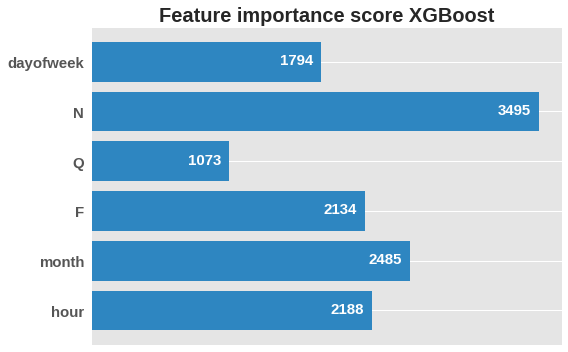

In [58]:
data = model_xgb.model.get_fscore()

Y = np.arange(len(list(data.keys())))
X = data.values()

label_x = data.values()
label_y = list(data.keys())

plt.subplots(figsize=(8,5))

plt.barh(Y,X,color='#2E86C1')

for x,y,s in zip(X,Y,label_x):
  plt.text(x-(len(str(s))*80),y-0.05,s,fontsize = 15,fontweight='bold',color='white')
plt.yticks(Y,label_y,fontweight='bold',fontsize=15)
plt.xticks([],[])
plt.title('Feature importance score XGBoost',fontweight='bold',fontsize=20)
plt.tight_layout()

In [59]:
print('Best score train:',model_xgb.model.best_score)

Best score train: 5.256487


In [60]:
model_xgb.load(path_models+'XGBoost_with_w.p')

###**4.2.4 CatBoost**

####**4.2.4.1 Tuning hyperparameters**

In [61]:
import catboost as ctb
from catboost import Pool

In [62]:
from sklearn.model_selection import ParameterGrid

numb_trees = {'iterations':[4,10]}
learning_rate = {'learning_rate':[i/100 for i in range(1,30)]}
tree_depth = {'depth':[i for i in range(1,16)]}
l2_leaf_reg = {'l2_leaf_reg':[i for i in np.arange(2,30,0.5)]}
random_strength = {'random_strength':[i/10 for i in range(0,10)]}
bagging_temperature =  {'bagging_temperature':list(range(1,10))}
max_bin = {'max_bin':range(1,255)}
symmetric_tree = {'grow_policy':['SymmetricTree'],
                  'min_child_samples':list(range(1,20)),
                 }
lossguide = {'grow_policy':['Lossguide'],
             'min_child_samples':list(range(5,20)),
             'num_leaves':list(range(1,20))
            }

numb_trees_grid = list(ParameterGrid(numb_trees))
tree_depth_grid = list(ParameterGrid(tree_depth))
l2_leaf_reg_grid = list(ParameterGrid(l2_leaf_reg))
random_strength_grid = list(ParameterGrid(random_strength))
bagging_temperature_grid = list(ParameterGrid(bagging_temperature))
max_bin_grid = list(ParameterGrid(max_bin))
# symmetric_tree_grid = list(ParameterGrid(symmetric_tree))
lossguide_grid = list(ParameterGrid(lossguide))
learning_rate_grid = list(ParameterGrid(learning_rate))

all_grid = [numb_trees_grid,tree_depth_grid,l2_leaf_reg_grid,random_strength_grid,bagging_temperature_grid,max_bin_grid,lossguide_grid,learning_rate_grid]

In [63]:
# from tqdm import tqdm
# from time import sleep
# # Define initial best params and MAE

# dtrain = Pool(X_train, label=y_train)
# dtest = Pool(X_test, label=y_test)
# deval = Pool(X_eval, label=y_eval)

# best_params = {}

# for i in tqdm(range(len(all_grid))):
#   min_mae = float("Inf")
#   for params in all_grid[i]:    
#     sleep(0.001)
#     # Run CV
#     params['eval_metric'] = 'MAE'
#     params['loss_function'] = 'MAE'
#     cv_results = ctb.cv(
#         dtrain,
#         params,
#         num_boost_round=999,
#         seed=42,
#         nfold=5,
#         early_stopping_rounds=200,
#         verbose = 0
#     )

#     # Update best MAE
#     mean_mae = cv_results['test-MAE-mean'].min()
#     boost_rounds = cv_results['test-MAE-mean'].argmin()

#     if mean_mae < min_mae:
#         min_mae = mean_mae
#         for npar in  list(params):
#           best_params[npar] = params[npar]
#           print('Params:',best_params)

# print("Best params: {}, mae: {}".format(best_params, min_mae))


####**4.2.4.2 Training**

In [64]:
import xgboost as xgb
import catboost as ctb



class CatBoostTrain():
  def __init__(self,num_boost_round,early_stopping_rounds,verbose,**kwargs):
    self.model = None
    self.verbose = verbose
    self.params = kwargs
    self.num_boost_round = num_boost_round
    self.early_stopping_rounds = early_stopping_rounds

  def fit(self,x_train,y_train,x_eval,y_eval):

    dtrain = Pool(x_train, label=y_train)

    deval = Pool(x_eval, label=y_eval)

    self.model = ctb.train(pool=dtrain,
                           params=self.params,
                           num_boost_round=self.num_boost_round,
                           eval_set=deval,
                           early_stopping_rounds=self.early_stopping_rounds,
                           verbose=self.verbose
                           )

    return self

  def predict(self,x_test,y_test):
      dtest = Pool(x_test, label=y_test)
      return self.model.predict(dtest)
  def save(self,path):
     self.model.save_model(path,format='json')


In [65]:
#CROSS VALIDATE
params = {'bagging_temperature': 1, 'depth': 6, 'grow_policy': 'Lossguide', 'iterations': 4,'num_leaves': 22, 'l2_leaf_reg': 27.0, 'learning_rate': 0.03, 'max_bin': 53, 'min_child_samples': 19, 'eval_metric': 'MAE', 'loss_function': 'MAE'}

model_ctb = CatBoostTrain(num_boost_round=999,early_stopping_rounds=10,verbose=0,**params)

In [66]:
model_ctb.fit(X_train, y_train, X_eval, y_eval)
model_ctb.save(path_models+'CatBoost_with_w.jason')

##**4.3 Resultados**

In [79]:
cv = KFold(n_splits=5,shuffle=False)
metrics = cross_val_score_predict(model_xgb,X_test,y_test,cv)
xgb_metrics = pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['cv 1','cv 2','cv 3','cv 4','cv 5'])
display(xgb_metrics)

,cv 1,cv 2,cv 3,cv 4,cv 5
SMAPE,3.118260,3.115161,3.303362,3.334966,3.148040
MSE,57.502333,45.576306,54.304442,55.979112,60.196328
MAE,5.267420,4.938118,5.417754,5.370686,5.311952


In [80]:
pd.DataFrame(xgb_metrics.mean(axis=1),columns=['Mean'])

,Mean
SMAPE,3.203958
MSE,54.711704
MAE,5.261186


In [81]:
cv = KFold(n_splits=5,shuffle=False)
metrics = cross_val_score_predict(model_ctb,X_test,y_test,cv)
ctb_metrics = pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['cv 1','cv 2','cv 3','cv 4','cv 5'])
display(ctb_metrics)

,cv 1,cv 2,cv 3,cv 4,cv 5
SMAPE,3.193767,2.739500,3.173207,3.314534,3.183275
MSE,62.634495,38.785985,55.778347,54.896216,58.229653
MAE,5.359105,4.336076,5.161396,5.411441,5.341990


In [82]:
ctb_metrics

,cv 1,cv 2,cv 3,cv 4,cv 5
SMAPE,3.193767,2.739500,3.173207,3.314534,3.183275
MSE,62.634495,38.785985,55.778347,54.896216,58.229653
MAE,5.359105,4.336076,5.161396,5.411441,5.341990


In [83]:
ctb_metrics.columns = pd.MultiIndex.from_product([['CatBoost'],ctb_metrics.columns])
xgb_metrics.columns = pd.MultiIndex.from_product([['XGBoost'],xgb_metrics.columns])
all_models = pd.concat([xgb_metrics,ctb_metrics],axis=1)
all_models

XGBoost                        ...   CatBoost                      
            cv 1       cv 2       cv 3  ...       cv 3       cv 4       cv 5
SMAPE   3.118260   3.115161   3.303362  ...   3.173207   3.314534   3.183275
MSE    57.502333  45.576306  54.304442  ...  55.778347  54.896216  58.229653
MAE     5.267420   4.938118   5.417754  ...   5.161396   5.411441   5.341990

[3 rows x 10 columns]

In [84]:
ctb_metrics.mean(axis=1)

SMAPE     3.120857
MSE      54.064939
MAE       5.122002
dtype: float64

In [85]:
y_pred_xgb = model_xgb.predict(X_test,y_test)
y_pred_ctb = model_ctb.predict(X_test,y_test)

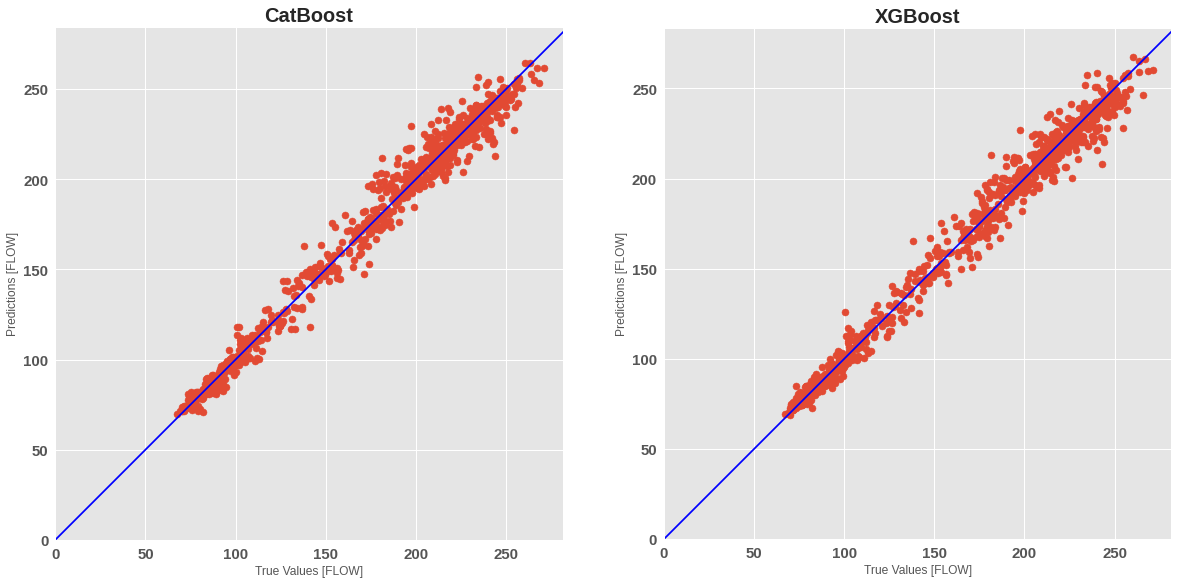

In [86]:
plt.subplots(1,2,figsize=(20,10))

plt.subplot(1,2,1)

plt.scatter(y_test, y_pred_ctb)
plt.xlabel('True Values [FLOW]')
plt.ylabel('Predictions [FLOW]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.xticks(fontweight='bold',fontsize=15)
plt.yticks(fontweight='bold',fontsize=15)
plt.title('CatBoost',fontweight='bold',fontsize=20)
_ = plt.plot([-100, 300], [-100, 300],color='blue')


plt.subplot(1,2,2)

plt.scatter(y_test, y_pred_xgb)
plt.xlabel('True Values [FLOW]')
plt.ylabel('Predictions [FLOW]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.xticks(fontweight='bold',fontsize=15)
plt.yticks(fontweight='bold',fontsize=15)
plt.title('XGBoost',fontweight='bold',fontsize=20)
_ = plt.plot([-100, 300], [-100, 300],color='blue')

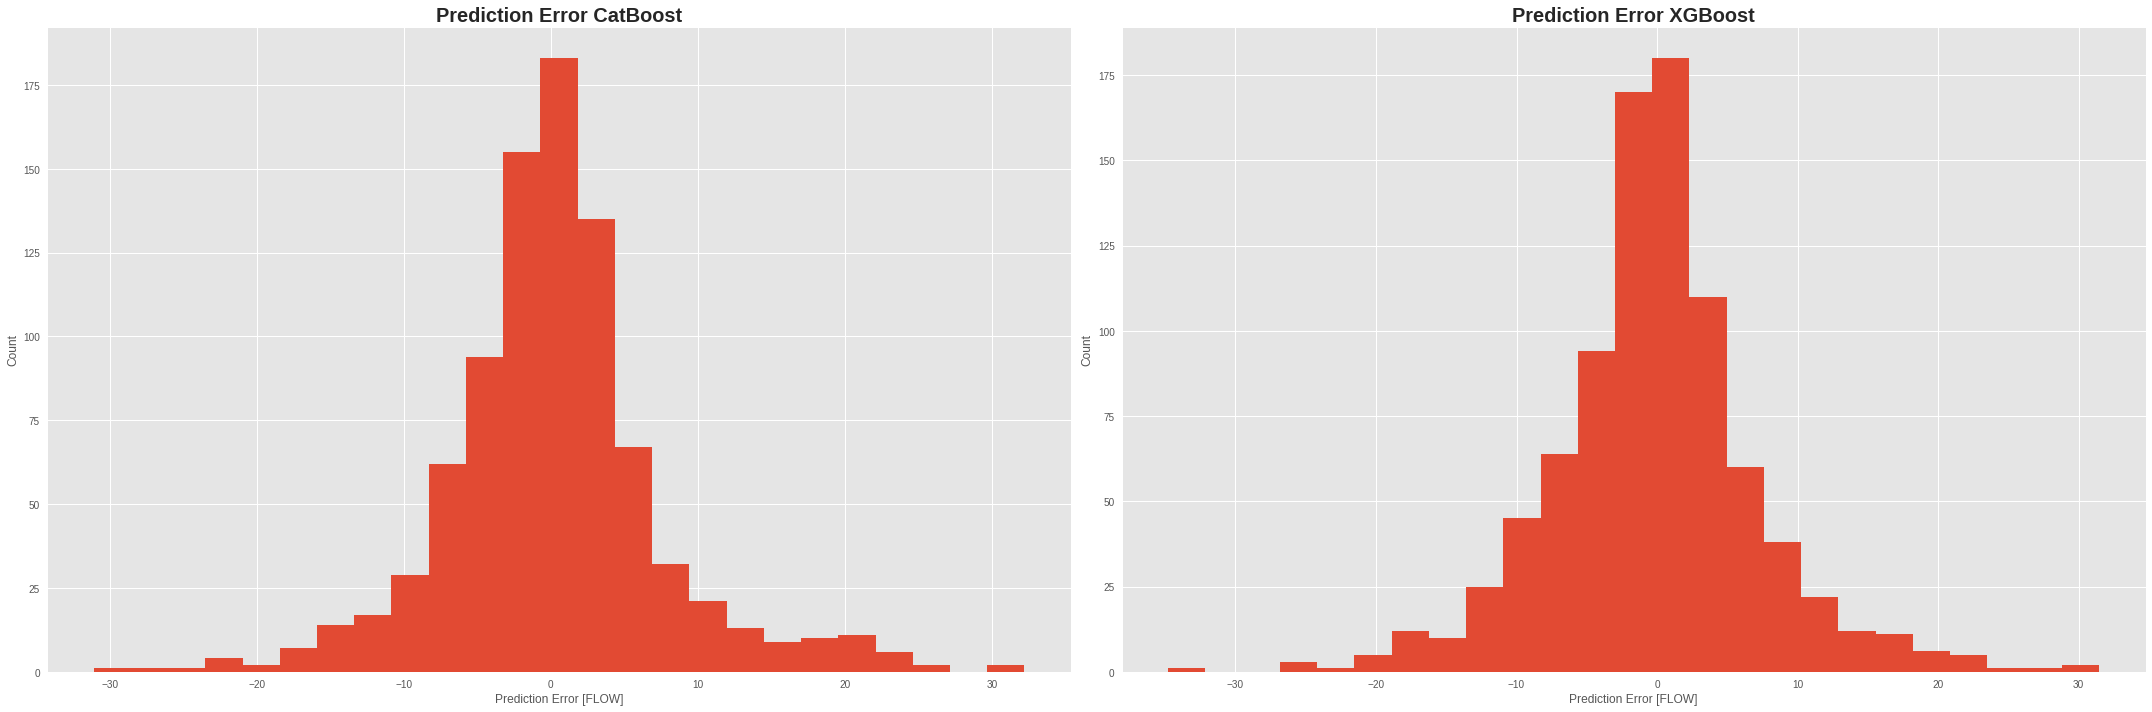

In [87]:
error = y_pred_ctb - y_test['FLOW']

plt.subplots(1,2,figsize=(30,10))

plt.subplot(1,2,1)
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [FLOW]")
plt.ylabel("Count")
plt.title('Prediction Error CatBoost',fontsize=20,fontweight='bold')
plt.tight_layout()

error = y_pred_xgb - y_test['FLOW']

plt.subplot(1,2,2)

plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [FLOW]")
plt.ylabel("Count")
plt.title('Prediction Error XGBoost',fontsize=20,fontweight='bold')
plt.tight_layout()